# 가위바위보 분류기 만들기

가위바위보 분류기를 만들어보도록 하자.  
 순서는 다음과 같다.
 
    1. 가위, 바위, 보 가 담긴 사진 Data set 을 만들고 전처리한다.  
    2. 분류기에게 Data set을 입력해 학습을 시킨다.  
    3. 잘 학습되었는지 Data set2 를 이용해 시험한다.  
  
가위바위보 분류기에 대한 Rubric 기준은 다음과 같다.

|평가문항|상세기준|
| --- | --- |  
|이미지 분류기 모델이 성공적으로 만들어 졌는가?|트레이닝이 정상 수행됨|
|오버피팅을 극복하기 위한 적절한 시도가 있었는가?|데이터셋의 다양성, 정규화 등의 시도가 적절하였음|
|분류모델의 test accuracy가 기준 이상 도달하였는가?|60% 이상 도달하였음|
    
### 목차
1.  Data set 만들기
2. 데이터 학습
3. 성능 시험 및 개선 (Try-6)
4. 회고 및 정리

## 1. Data set 만들기

가위바위보 무엇을 냈는지 보려면 당연히 가위바위보 사진이 필요하다,  
분류기가 제대로 작동하려면 적어도 각각 100장 이상의 데이터 사진을 불러와야 한다.

   ### 1-1. 데이터 사진 만들기
구글의 teachable machine 사이트에서는 웹캠을 이용해 짧은 시간 내에 사진 파일을 만들 수 있는 프로그램이 제공되고 있다.

[Teachable Machine](https://teachablemachine.withgoogle.com/)



<img src="./img/site.PNG" width="300px" height="200px"></img><img src="./img/cam.gif" width="300px" height ="200px"></img>

넉넉하게 가위, 바위, 보 당 300장의 이미지 샘플을 만들어 저장했다.

### 1-2 데이터 전처리
데이터 사진은 잘 불러왔다면, 해당 이미지 파일들의 정보를 가위, 바위, 보 별로  
라벨링 하여 28x28의 사이즈로 처리하려 한다.

#### 1-2-1 Resize
가위, 바위와 보 를 같은 사이즈로 변경해 주었다.

In [2]:
from PIL import Image
import glob
import os

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg") #리스트 안에 이미지 요소 담김
    
    target_size = (28,28) #바꾸고 싶은 사이즈
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS) #resize 메서드로 사이즈 변경
        new_img.save(img, "JPEG")
    print("{} clear".format(len(images)))
        
image_dir_path_scissors = os.getenv("HOME") + "/aiffel/rock_scissors_paper/scissors"
image_dir_path_rock = os.getenv("HOME") + "/aiffel/rock_scissors_paper/rock"
image_dir_path_paper = os.getenv("HOME") + "/aiffel/rock_scissors_paper/paper"

resize_images(image_dir_path_scissors)
resize_images(image_dir_path_rock)
resize_images(image_dir_path_paper)

342 clear
302 clear
308 clear


---
#### 1-2-2 Labeling
  
이제는 이 사진을 바탕으로 가위:0 바위:1 보:2 라는 클래스를 선정해 준다.

In [4]:
import numpy as np

def load_data(img_path, number_of_data=952):  # 가위바위보 이미지 개수의 총 합
    # 가위 : 0, 바위 : 1, 보 : 2
    
    img_size=28
    color=3
    
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissors_paper"
(x_train, y_train)=load_data(image_dir_path)

print("x_train에 담긴 자료의 행렬: {}".format(x_train.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 952 입니다.
x_train에 담긴 자료의 행렬: (952, 28, 28, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (952,)


이러면 (x_train, y_train) 에서  
x에는 각 사진의 모든 데이터(크기, 색깔) 이,  
y에는 해당 데이터의 정답 (가위 0 인지 바위 1 인지 보 2 인지) 이 들어간 행렬이 만들어진다.

예를 들어 x_train 의 자료 구조는 가장 안에 3개의 rgb 값이 있고, 그 값들이 가로 순서로 정렬되어 있고, 그 값들이 세로 순서로 정렬되어 있다.


In [3]:
print('첫번째 데이터의 rgb 값 :', x_train[0][0][0])
print('첫번째 줄의 rgb값 순서 :\n', x_train[0][0])

첫번째 데이터의 rgb 값 : [110 119 124]
첫번째 줄의 rgb값 순서 :
 [[110 119 124]
 [117 126 131]
 [128 137 142]
 [138 147 152]
 [145 154 159]
 [151 160 165]
 [155 164 169]
 [158 167 172]
 [166 173 181]
 [167 174 182]
 [168 175 183]
 [168 175 183]
 [169 176 184]
 [168 175 183]
 [168 175 183]
 [167 174 182]
 [164 174 183]
 [164 174 183]
 [164 174 183]
 [163 173 182]
 [162 172 181]
 [161 171 180]
 [160 169 176]
 [159 168 175]
 [158 167 174]
 [157 166 173]
 [157 164 170]
 [156 163 169]]


이렇게 3x28x28 의 데이터를 가진 사진이 총 952장 있으므로  
x_train 은 (952,28,28,3) 4차원의 행렬구조를 갖춘다

사진 데이터 하나를 뽑아보면 다음과 같다

라벨:  0


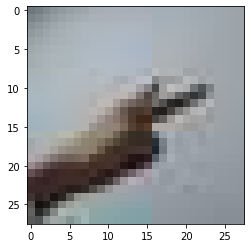

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

---
#### 1-2-3 Nomalization
인공지능 모델을 학습시킬 때, 일반적으로 모든 데이터를 0~1 사이의 값으로  
정규화 시켜 사용한다.


In [5]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print('정규화된 rgb값의 예시 :\n', x_train_norm[0][0])

정규화된 rgb값의 예시 :
 [[0.43137255 0.46666667 0.48627451]
 [0.45882353 0.49411765 0.51372549]
 [0.50196078 0.5372549  0.55686275]
 [0.54117647 0.57647059 0.59607843]
 [0.56862745 0.60392157 0.62352941]
 [0.59215686 0.62745098 0.64705882]
 [0.60784314 0.64313725 0.6627451 ]
 [0.61960784 0.65490196 0.6745098 ]
 [0.65098039 0.67843137 0.70980392]
 [0.65490196 0.68235294 0.71372549]
 [0.65882353 0.68627451 0.71764706]
 [0.65882353 0.68627451 0.71764706]
 [0.6627451  0.69019608 0.72156863]
 [0.65882353 0.68627451 0.71764706]
 [0.65882353 0.68627451 0.71764706]
 [0.65490196 0.68235294 0.71372549]
 [0.64313725 0.68235294 0.71764706]
 [0.64313725 0.68235294 0.71764706]
 [0.64313725 0.68235294 0.71764706]
 [0.63921569 0.67843137 0.71372549]
 [0.63529412 0.6745098  0.70980392]
 [0.63137255 0.67058824 0.70588235]
 [0.62745098 0.6627451  0.69019608]
 [0.62352941 0.65882353 0.68627451]
 [0.61960784 0.65490196 0.68235294]
 [0.61568627 0.65098039 0.67843137]
 [0.61568627 0.64313725 0.66666667]
 [0.6117647

---
모든 데이터 전처리가 끝났다!!!!  
우리가 만든 데이터는   
*(x_train_norm , y_train )* 이다.

## 2. 데이터 학습

데이터가 모두 준비되었다면, 데이터간의 차이를 알아서 패턴화하고 구별해주는  
'딥러닝 네트워크' 가 필요하다.

tensorflow 에서는 이러한 딥러닝 네트워크 제작을 지원해주는  
Sequential API 를 제공하고 있다.

아래는 그 사용이다.

### 2-1. 딥러닝 네트워크 만들기


In [10]:
import tensorflow as tf
from tensorflow import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


각 메서드와 매개변수에 대한 설명:
> 1. Conv2D(a, b, activation='', input_shape=())  
a : 구분할 이미지 특징의 갯수
2. Dense(a, activation="")  
a : 알고리즘의 복잡도 (perceptron의 사용갯수)
*input_shape : 입력이미지 형태 ( 가로픽셀, 세로픽셀, 흑백=1/컬러=3 )
*activation : 사용할 활성함수

마지막의 Dense 함수의 a 는 구분할 클래스의 수를 지정하면 된다.  
우리의 경우 가위, 바위, 보 로 3개가 필요하므로 3을 넣자.

---

우리가 만든 이 네트워크는 model.summary()로 확인해 볼 수 있다.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

## 2-2 데이터로 딥러닝 네트워크 학습시키기

아래는 우리가 준비한 전처리 데이터를 가지고 네트워크 학습을 10회 반복한다는 코드이다.

In [8]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
30/30 [==============================] - 3s 6ms/step - loss: 1.0376 - accuracy: 0.4737
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7599 - accuracy: 0.7405
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.8477
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.9212
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.2155 - accuracy: 0.9496
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9580
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.1155 - accuracy: 0.9790
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.1044 - accuracy: 0.9779
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9905
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.0429 - accuracy: 0.9979


정확도를 나타내는 accuracy의 값이 점점 높아지는 것을 볼 수 있다.  

## 3. 성능 시험하기 
### 3-1 테스트 데이터 준비하기

내가 만든 딥워킹이가 잘 작동하는지 확인하기 위해선 test 데이터를 필요로 한다.  
나는 내 친구가 만든 가위바위보 영상 사진을 가져왔다.  
~~친구가 없다면 반댓손으로 다시 만들자~~

102 clear
101 clear
100 clear
학습데이터(x_train)의 이미지 개수는 303 입니다.
x_test에 담긴 자료의 행렬: (952, 28, 28, 3)
y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: (952,)
test값 전처리 복붙으로 손쉽게 완료!
해당 사진의 라벨 : 0


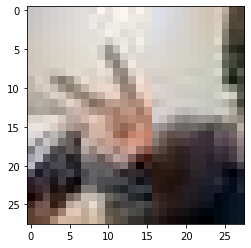

In [9]:
image_dir_path_scissors_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test/scissors"
image_dir_path_rock_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test/rock"
image_dir_path_paper_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test/paper"

resize_images(image_dir_path_scissors_test)
resize_images(image_dir_path_rock_test)
resize_images(image_dir_path_paper_test)

image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test"
(x_test, y_test)=load_data(image_dir_path_test)

print("x_test에 담긴 자료의 행렬: {}".format(x_test.shape))
print("y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_test.shape))
x_test_norm = x_train/255.0

print('test값 전처리 복붙으로 손쉽게 완료!')
plt.imshow(x_test[0])
print('해당 사진의 라벨 :',y_test[0])

### 3-2. 테스트 데이터로 측정하기

In [10]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

30/30 - 0s - loss: 5.9817 - accuracy: 0.1492
test_loss: 5.981659889221191 
test_accuracy: 0.14915966987609863


---
이럴수가,, 정확도가 약 15%가 나왔다.
뭐가 잘못된걸까?

하...


### 3-3 측정 결과 분석하기  
.predict() 함수를 사용하면 내가 만든 네트워크 모델의 추론과정을  
확률분포로 뽑아볼 수 있다.

model.predict() 결과 :  [9.9997127e-01 8.7066237e-06 2.0021884e-05]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  2

실제 데이터의 사진


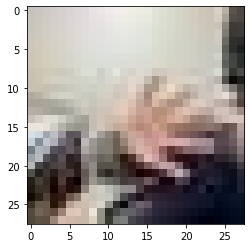

In [15]:
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=220  #220번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
print('\n실제 데이터의 사진')
plt.show()


확률 분포를 보면 해당 데이터는 1과 가장 가까운 0번라벨(바위)라고 판단했지만
사실 실제 데이터의 사진은 보자기다. 왜 이 친구가 실수를 한걸까?

-보니까 내 사진은 뒤가 하얀데 내 친구는
뒤가 너저분하다. 그러게 청소좀 하지.

-화질이 너무 깨져서 그런거 아닐까? 사람도 분간하기 힘들잖어

---
그러므로 다시 데이터 전처리로 돌아가,  

1. 다른 train 값 을 더 추가하여 사용
2. 데이터 설계에서 epoch 값 증가

를 중심으로 코드를 수정하기로 했다.

---
### 3-4. 분석에 따라 코드 수정하기

#### Try 1.

1. 다른 train 값 각각 500장씩을 새로 불러와 리사이징, 라벨링 작업을 실시했다

In [11]:
def load_data(img_path, number_of_data=1500):  #def number_of_data=952 에서 number_of_data=1500으로 변경했음
    
    img_size=28
    color=3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


image_dir_path_scissors = os.getenv("HOME") + "/aiffel/rsp_sample/scissors"
image_dir_path_rock = os.getenv("HOME") + "/aiffel/rsp_sample/rock"
image_dir_path_paper = os.getenv("HOME") + "/aiffel/rsp_sample/paper"

resize_images(image_dir_path_scissors)
resize_images(image_dir_path_rock)
resize_images(image_dir_path_paper)

image_dir_path = os.getenv("HOME") + "/aiffel/rsp_sample"
(x_train, y_train)=load_data(image_dir_path)

print("x_train에 담긴 자료의 행렬: {}".format(x_train.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_train.shape))
x_train_norm = x_train/255.0

500 clear
500 clear
500 clear
학습데이터(x_train)의 이미지 개수는 1500 입니다.
x_train에 담긴 자료의 행렬: (1500, 28, 28, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (1500,)


---
2. 이를 바탕으로 epoch 값을 20으로 늘려 재학습 후 시험해보도록 하자.


In [12]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=20)

Epoch 1/20
47/47 [==============================] - 1s 5ms/step - loss: 1.3868 - accuracy: 0.3620
Epoch 2/20
47/47 [==============================] - 0s 3ms/step - loss: 0.9553 - accuracy: 0.5340
Epoch 3/20
47/47 [==============================] - 0s 3ms/step - loss: 0.7468 - accuracy: 0.6973
Epoch 4/20
47/47 [==============================] - 0s 3ms/step - loss: 0.5427 - accuracy: 0.8000
Epoch 5/20
47/47 [==============================] - 0s 3ms/step - loss: 0.4002 - accuracy: 0.8660
Epoch 6/20
47/47 [==============================] - 0s 3ms/step - loss: 0.2997 - accuracy: 0.9013
Epoch 7/20
47/47 [==============================] - 0s 3ms/step - loss: 0.2176 - accuracy: 0.9400
Epoch 8/20
47/47 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9713
Epoch 9/20
47/47 [==============================] - 0s 3ms/step - loss: 0.1175 - accuracy: 0.9827
Epoch 10/20
47/47 [==============================] - 0s 3ms/step - loss: 0.1014 - accuracy: 0.9813
Epoch 11/20
47/47 [

In [13]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

30/30 - 0s - loss: 14.6183 - accuracy: 0.1418
test_loss: 14.61825942993164 
test_accuracy: 0.1418067216873169


이럴리가 없다. 우선 epoch 값을 5로 줄여 재학습해보았다.

#### Try 1-2.

In [16]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=5)

Epoch 1/5
47/47 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.9993
Epoch 2/5
47/47 [==============================] - 0s 3ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 3/5
47/47 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 4/5
47/47 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 5/5
47/47 [==============================] - 0s 3ms/step - loss: 9.8273e-04 - accuracy: 1.0000


In [17]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

30/30 - 0s - loss: 19.8458 - accuracy: 0.1418
test_loss: 19.845796585083008 
test_accuracy: 0.1418067216873169


성능은 그대로 좋지 않다.
다시 한번 생각해봤다.

학습 accuracy 가 저렇게 덜떨어진 이유가 뭘까?

---
내 acuuracy 를 올리기 위한 방법은 여러가지가 있다.

1. train 데이터 조작 (변경, 확대, 축소)
2. test 데이터 조작 (변경, 축소)
3. epoch 값 변경 (# 너무 올려도 오버피팅현상이 생기니 적절한 값 찾기)
4. hyperparameter 값 변경 (아직 이에 대해 잘 모름)

고심히 생각해본 결과 
train 데이터와 test 데이터의 배경이 너무 다르고 또 화질이 너무 좋지 않다고 판단했다.

#### Try 2.

그러므로 다시 데이터 전처리로 돌아가,  

1. image 사이즈 변경
2. test 데이터, 배경이 덜 어지러운 이미지로 변경
3. 데이터 설계에서 반복횟수인 epoch 값을 늘려보도록 하겠다.

---

In [6]:
#train 값의 이미지 56px 로 변경

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg") 
    
    target_size = (56,56) #바꾸고 싶은 사이즈
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS) 
        new_img.save(img, "JPEG")
    print("{} clear".format(len(images)))
        
image_dir_path_scissors = os.getenv("HOME") + "/aiffel/rock_scissors_paper/scissors"
image_dir_path_rock = os.getenv("HOME") + "/aiffel/rock_scissors_paper/rock"
image_dir_path_paper = os.getenv("HOME") + "/aiffel/rock_scissors_paper/paper"

resize_images(image_dir_path_scissors)
resize_images(image_dir_path_rock)
resize_images(image_dir_path_paper)


def load_data(img_path, number_of_data=952): 
    
    img_size=56
    color=3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissors_paper"
(x_train, y_train)=load_data(image_dir_path)

print("x_train에 담긴 자료의 행렬: {}".format(x_train.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_train.shape))
x_train_norm = x_train/255.0

342 clear
302 clear
308 clear
학습데이터(x_train)의 이미지 개수는 952 입니다.
x_train에 담긴 자료의 행렬: (952, 56, 56, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (952,)


라벨:  0


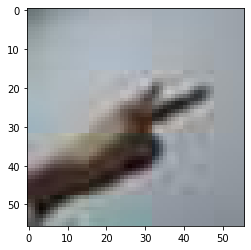

In [30]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

조금 더 선명해진 사진의 화질이 느껴진다.

늘어난 픽셀에 따라 딥러닝 네트워크를 조정해주고 학습시켜보자.

In [39]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(56,56,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=15)

Model에 추가된 Layer 개수:  7
Epoch 1/15
30/30 [==============================] - 0s 4ms/step - loss: 1.0588 - accuracy: 0.4233
Epoch 2/15
30/30 [==============================] - 0s 4ms/step - loss: 0.8183 - accuracy: 0.6912
Epoch 3/15
30/30 [==============================] - 0s 4ms/step - loss: 0.4854 - accuracy: 0.8372
Epoch 4/15
30/30 [==============================] - 0s 3ms/step - loss: 0.2890 - accuracy: 0.9065
Epoch 5/15
30/30 [==============================] - 0s 3ms/step - loss: 0.2337 - accuracy: 0.9391
Epoch 6/15
30/30 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.9643
Epoch 7/15
30/30 [==============================] - 0s 3ms/step - loss: 0.0930 - accuracy: 0.9821
Epoch 8/15
30/30 [==============================] - 0s 3ms/step - loss: 0.0794 - accuracy: 0.9800
Epoch 9/15
30/30 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9884
Epoch 10/15
30/30 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.

100 clear
100 clear
100 clear
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test에 담긴 자료의 행렬: (952, 56, 56, 3)
y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: (952,)
test값 전처리 복붙으로 손쉽게 완료!
해당 사진의 라벨 : 0


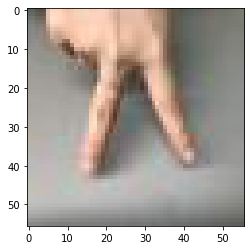

In [34]:
image_dir_path_scissors_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_2/scissors"
image_dir_path_rock_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_2/rock"
image_dir_path_paper_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_2/paper"

resize_images(image_dir_path_scissors_test)
resize_images(image_dir_path_rock_test)
resize_images(image_dir_path_paper_test)

image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_2"
(x_test, y_test)=load_data(image_dir_path_test)

print("x_test에 담긴 자료의 행렬: {}".format(x_test.shape))
print("y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_test.shape))
x_test_norm = x_train/255.0

print('test값 전처리 복붙으로 손쉽게 완료!')
plt.imshow(x_test[0])
print('해당 사진의 라벨 :',y_test[0])

말한 바와 같이 뒷면이 하얀 배경을 가진 데이터를 불러왔다

In [40]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

30/30 - 0s - loss: 9.0367 - accuracy: 0.1492
test_loss: 9.036745071411133 
test_accuracy: 0.14915966987609863


아무리 값을 바꾸고 이것저것 시도해봐도 나아지지가 않는다..  

#### Try 3.

여기서 불현듯
test사진과 비슷한 구도와 손동작으로 train 영상을 찍는다면, 훨씬 훌륭한 학습을 하지 않을까 싶어 다시 train 자료를 준비하기로
생각했다.

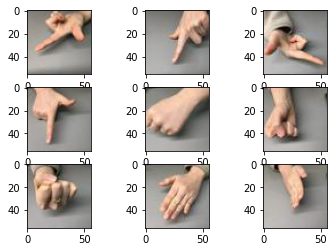

In [62]:
fig = plt.figure()
count = 1
for i in range(1, 10):
    ax = fig.add_subplot(3,3,i)
    plt.imshow(x_test[count])
    count += 29

상단의 test데이터는 바닥면에 엄지와 검지로 만든 가위, 바위, 그리고 보를 보여주고 있다. 이와 비슷하게 데이터를 만들어 보도록 하겠다.

In [59]:
image_dir_path_scissors = os.getenv("HOME") + "/aiffel/rock_scissors_paper_2/scissors"
image_dir_path_rock = os.getenv("HOME") + "/aiffel/rock_scissors_paper_2/rock"
image_dir_path_paper = os.getenv("HOME") + "/aiffel/rock_scissors_paper_2/paper"

resize_images(image_dir_path_scissors)
resize_images(image_dir_path_rock)
resize_images(image_dir_path_paper)


def load_data(img_path, number_of_data=300):    
    img_size=56
    color=3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissors_paper_2"
(x_train, y_train)=load_data(image_dir_path)

print("x_train에 담긴 자료의 행렬: {}".format(x_train.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_train.shape))
x_train_norm = x_train/255.0

100 clear
100 clear
100 clear
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train에 담긴 자료의 행렬: (300, 56, 56, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (300,)


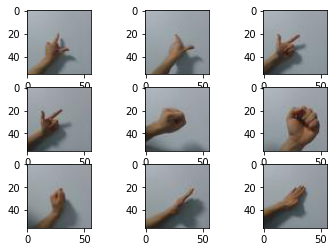

In [61]:
fig = plt.figure()
count = 1
for i in range(1, 10):
    ax = fig.add_subplot(3,3,i)
    plt.imshow(x_train[count])
    count += 29


In [87]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(56,56,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=17)

Epoch 1/17
10/10 [==============================] - 0s 4ms/step - loss: 1.0809 - accuracy: 0.4133
Epoch 2/17
10/10 [==============================] - 0s 4ms/step - loss: 0.9417 - accuracy: 0.6567
Epoch 3/17
10/10 [==============================] - 0s 4ms/step - loss: 0.8412 - accuracy: 0.6867
Epoch 4/17
10/10 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.7167
Epoch 5/17
10/10 [==============================] - 0s 4ms/step - loss: 0.5408 - accuracy: 0.8233
Epoch 6/17
10/10 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.8300
Epoch 7/17
10/10 [==============================] - 0s 4ms/step - loss: 0.3557 - accuracy: 0.8933
Epoch 8/17
10/10 [==============================] - 0s 4ms/step - loss: 0.2823 - accuracy: 0.9233
Epoch 9/17
10/10 [==============================] - 0s 4ms/step - loss: 0.2182 - accuracy: 0.9533
Epoch 10/17
10/10 [==============================] - 0s 4ms/step - loss: 0.1745 - accuracy: 0.9567
Epoch 11/17
10/10 [

In [88]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

30/30 - 0s - loss: 5.6904 - accuracy: 0.2511
test_loss: 5.69038724899292 
test_accuracy: 0.2510504126548767


!!! 눈에 띄게 높아진 정확도를 볼 수 있다.
하지만 사실상 가위바위보 분류는 하나로 찍기만 해도 33%는 나와야 하는데,
그에 비하면 터무니없는 확률이다.

그럼 이미지 간의 유사도를 더 높여보면 어떨까?

#### Try 4.

결국 Train 이미지와 test이미지를 내가 다 준비해보기로 하였다.

In [95]:

#train, test 데이터 리사이징 및 라벨링 
image_dir_path_scissors = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3/scissors"
image_dir_path_rock = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3/rock"
image_dir_path_paper = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3/paper"

resize_images(image_dir_path_scissors)
resize_images(image_dir_path_rock)
resize_images(image_dir_path_paper)

def load_data(img_path, number_of_data=1500):    
    img_size=56
    color=3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3"
(x_train, y_train)=load_data(image_dir_path)

print("x_train에 담긴 자료의 행렬: {}".format(x_train.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_train.shape))
x_train_norm = x_train/255.0



image_dir_path_scissors_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3/scissors"
image_dir_path_rock_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3/rock"
image_dir_path_paper_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3/paper"

resize_images(image_dir_path_scissors_test)
resize_images(image_dir_path_rock_test)
resize_images(image_dir_path_paper_test)

image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3"
(x_test, y_test)=load_data(image_dir_path_test)
x_test_norm = x_test/255.0


print("x_test에 담긴 자료의 행렬: {}".format(x_test.shape))
print("y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_test.shape))

200 clear
200 clear
200 clear
학습데이터(x_train)의 이미지 개수는 600 입니다.
x_train에 담긴 자료의 행렬: (600, 56, 56, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (600,)
200 clear
200 clear
200 clear
학습데이터(x_train)의 이미지 개수는 600 입니다.
x_test에 담긴 자료의 행렬: (600, 56, 56, 3)
y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: (600,)


In [123]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(56,56,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
19/19 [==============================] - 0s 4ms/step - loss: 1.0400 - accuracy: 0.4850
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.8033
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 0.3623 - accuracy: 0.8917
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9483
Epoch 5/10
19/19 [==============================] - 0s 4ms/step - loss: 0.1245 - accuracy: 0.9700
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9833
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0452 - accuracy: 0.9917
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0278 - accuracy: 0.9983
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0247 - accuracy: 0.9967
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0182 - accuracy: 0.9983


In [124]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 0s - loss: 1.4248 - accuracy: 0.5900
test_loss: 1.424778699874878 
test_accuracy: 0.5899999737739563


놀랍다...! 곧 60%에 도달할 것이다. 
traing 데이터 셋을 더 채운다면 분명 더 높은 적중률을 보일 것이다.

#### Try 5

카테고리별로 약 500장을 더 넣어 훈련시켰다.

In [47]:
#train, test 데이터 리사이징 및 라벨링 
image_dir_path_scissors = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3/scissors"
image_dir_path_rock = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3/rock"
image_dir_path_paper = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3/paper"

resize_images(image_dir_path_scissors)
resize_images(image_dir_path_rock)
resize_images(image_dir_path_paper)

def load_data(img_path, number_of_data=1980):    
    img_size=56
    color=3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissors_paper_3"
(x_train, y_train)=load_data(image_dir_path)

print("x_train에 담긴 자료의 행렬: {}".format(x_train.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_train.shape))
x_train_norm = x_train/255.0



image_dir_path_scissors_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3/scissors"
image_dir_path_rock_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3/rock"
image_dir_path_paper_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3/paper"

resize_images(image_dir_path_scissors_test)
resize_images(image_dir_path_rock_test)
resize_images(image_dir_path_paper_test)

image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_3"
(x_test, y_test)=load_data(image_dir_path_test)
x_test_norm = x_test/255.0


print("x_test에 담긴 자료의 행렬: {}".format(x_test.shape))
print("y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_test.shape))

660 clear
660 clear
660 clear
학습데이터(x_train)의 이미지 개수는 1980 입니다.
x_train에 담긴 자료의 행렬: (1980, 56, 56, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (1980,)
200 clear
200 clear
200 clear
학습데이터(x_train)의 이미지 개수는 600 입니다.
x_test에 담긴 자료의 행렬: (1980, 56, 56, 3)
y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: (1980,)


In [50]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(56,56,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=7)

Epoch 1/7
62/62 [==============================] - 1s 4ms/step - loss: 0.7827 - accuracy: 0.6303
Epoch 2/7
62/62 [==============================] - 0s 4ms/step - loss: 0.2222 - accuracy: 0.9323
Epoch 3/7
62/62 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 0.9768
Epoch 4/7
62/62 [==============================] - 0s 4ms/step - loss: 0.0506 - accuracy: 0.9879
Epoch 5/7
62/62 [==============================] - 0s 4ms/step - loss: 0.0227 - accuracy: 0.9975
Epoch 6/7
62/62 [==============================] - 0s 4ms/step - loss: 0.0192 - accuracy: 0.9949
Epoch 7/7
62/62 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9980


In [51]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

62/62 - 0s - loss: 4.3338 - accuracy: 0.2919
test_loss: 4.333792686462402 
test_accuracy: 0.29191920161247253


?? 진짜 말도 안되지만 확률이 다시 줄어들었다.
하지만 다행히도 **Try 4**에서 정말 훌륭한 확률이 나왔기 때문에

다시 초심으로 돌아가 Try 4를 해보기로 한다.

---

#### Try 6

새로운 마음으로 지금까지 재용했던 함수를 다시 정의하고
이미지도 28pixel 로 집어 넣어 써보도록 하자.

## Try 6-1. 데이터 전처리 (요약)

In [9]:
from PIL import Image
import glob
import os
import numpy as np

# data resizing
def resize_images_final(img_path):
    images=glob.glob(img_path + "/*.jpg") 
    
    target_size = (28,28) #바꾸고 싶은 사이즈
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS) 
        new_img.save(img, "JPEG")
    print("{} clear".format(len(images)))
        

#data labeling
def load_data_final(img_path, number_of_data): 
    # 가위 : 0, 바위 : 1, 보 : 2
    
    img_size=28
    color=3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.\n")
    return imgs, labels


# train_data
image_dir_path_scissors_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_4/scissors/scissors"
image_dir_path_rock_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_4/rock/rock"
image_dir_path_paper_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_4/paper/paper"

resize_images_final(image_dir_path_scissors_final)
resize_images_final(image_dir_path_rock_final)
resize_images_final(image_dir_path_paper_final)

image_dir_path_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_4"
(x_train_final, y_train_final)=load_data_final(image_dir_path_final, 1890)  # 사진 갯수

# train_data nomalization
x_train_norm_final = x_train_final/255.0


# test_data
image_dir_path_scissors_test_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_4/scissors/scissors"
image_dir_path_rock_test_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_4/rock/rock"
image_dir_path_paper_test_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_4/paper/paper"

resize_images_final(image_dir_path_scissors_test_final)
resize_images_final(image_dir_path_rock_test_final)
resize_images_final(image_dir_path_paper_test_final)

image_dir_path_test_final = os.getenv("HOME") + "/aiffel/rock_scissors_paper_test_4"
(x_test_final, y_test_final)=load_data_final(image_dir_path_test_final, 540) # 사진 갯수

# test_data nomalization

x_test_norm_final = x_test_final/255.0

print("x_train에 담긴 자료의 행렬: {}".format(x_train_final.shape))
print("y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: {}\n".format(y_train_final.shape))

print("x_test에 담긴 자료의 행렬: {}".format(x_test_final.shape))
print("y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: {}".format(y_test_final.shape))




630 clear
630 clear
630 clear
학습데이터(x_train)의 이미지 개수는 1890 입니다.

180 clear
180 clear
180 clear
학습데이터(x_train)의 이미지 개수는 540 입니다.

x_train에 담긴 자료의 행렬: (1890, 28, 28, 3)
y_train에 담긴 0,1,2(가위바위보) 라벨의 개수: (1890,)

x_test에 담긴 자료의 행렬: (540, 28, 28, 3)
y_test에 담긴 0,1,2(가위바위보) 라벨의 개수: (540,)


## Try 6-2. 딥러닝 네트워크 모델 제작 및 학습

In [14]:
import tensorflow as tf
from tensorflow import keras

model_final=keras.models.Sequential()
model_final.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model_final.add(keras.layers.MaxPool2D(2,2))
model_final.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model_final.add(keras.layers.MaxPooling2D((2,2)))
model_final.add(keras.layers.Flatten())
model_final.add(keras.layers.Dense(32, activation='relu'))
model_final.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model_final.layers))

model_final.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_final.fit(x_train_norm_final, y_train_final, epochs=10)

Model에 추가된 Layer 개수:  7
Epoch 1/10
60/60 [==============================] - 0s 3ms/step - loss: 0.9125 - accuracy: 0.6238
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.4968 - accuracy: 0.8296
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.9016
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.1707 - accuracy: 0.9466
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.1046 - accuracy: 0.9720
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.9804
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9915
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9974
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0320 - accuracy: 0.9963
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.

## Try 6-3. 성능 평가

In [16]:
test_loss_final, test_accuracy_final = model_final.evaluate(x_test_norm_final,y_test_final, verbose=2) #evaluate 함수로 다른 데이터를 통해 네트워크 평가
print("test_loss: {} ".format(test_loss_final))
print("test_accuracy: {}".format(test_accuracy_final))

17/17 - 0s - loss: 0.1481 - accuracy: 0.9315
test_loss: 0.14811034500598907 
test_accuracy: 0.9314814805984497


나왔다.

# 4 회고 및 정리

### Clear Point
1. train 과 test set 의 유사도 높임
2. train set의 volume 증가
3. 이미지 데이터 resizing 및 nomaliztion 으로 overfiting 최소화

### Checking Point
 > 1. **Try & Failure**  
   6번 Try라고는 했지만, 사실 한번 실패할 때마다 이런저런 파라미터를 보고, 코드를 수정하는 등
   전체적으로는 약 60번 정도의 시도를 해 보았다.
   처음에는 속도도 빠르게 나가고 즐거웠지만, 내가 통제할 수 없는 어떤 부분에서 막힐 때 부터는  
   진이 빠지고 의욕이 줄어든 것이 사실이다.
   
> 2. **머신러닝 메서드 이해의 부족**  
   전체적인 머신러닝의 맥락 ( 데이터 전처리 - 모델 선정 및 학습 - 모델 평가 ) 에 대해선 이해했지만,  
   아직 왜 가위바위보 분류 모델로 **Tensorflow의 keras 모델을 쓰는지**,  
   그리고 **그 모델 안에서 어떤 식으로 학습이 이루어지는지**를  
   이해하지 못했다. 때문에 코드 수정 과정에서 이 모델 선정 및 학습 파라미터 설정 부분은 개선시킬 수가 없었다.
   때문에 내가 이해한 선에서 (하이퍼 파라미터를 통해 데이터 분류를 복잡화, 다량화 시킬 수 있다.) 최대한 수정해보았다.
   
> 3. **기초 라이브러리에 대한 메서드 숙달치 부족**  
   물론 딥러닝보다는 훨씬 잘 알고 있지만, glob, os, numpy 관련 메서드 사용능력이 부족하다고 느꼈다.  
   프로젝트를 진행하면서도 차차 실력이 늘겠지만, 더 원활하고 효유적인 진행을 위해 따로 메서드와 작동방식을 숙지해야 한다고 생각했다.
   
 
### 다짐  

위에서와 같이 아직 부족한 점이 많다. 하지만 내 공부 순서에 따르면 지금은 딥러닝 모델 메서드에 대해 공부하기 보다는 순차적으로
기본적인 메서드를 익히고 , 라이브러리를 이해하는 과정부터 시작해야 한다고 생각한다.  
특히 파이썬에 대한 기본 이해(정규표현식 중심), 데이터 전처리 관련 기본 메서드(numpy,pandas,os 중심)에 대해  
우선적으로 정리를 해 나갈 생각이다. 아직은 기본기를 쌓을 때다.  
탄탄한 지반으로 딥러닝이라는 나무의 뿌리를 단단히 자리잡게 만들고 싶다.